In [1]:
epochs = 10

# Federated Learning on MNIST using a CNN

## Imports and Specifications

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# check if imports were done properly
print(torch.__version__)
print (torch.cuda.is_available())

1.4.0
True


In [3]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

# No secure randomness for this implementation

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\jason\miniconda3\envs\rcp2020\lib\site-packages\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.4.so'


### Model Params

In [4]:
class Arguments():
    def __init__(self):
        self.batch_size = 256
        self.test_batch_size = 1000
        self.epochs = epochs
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 32
        self.save_model = True

        # DP
        self.using_DP = True

        # train_dp
        self.stddev = 0.1

        # train_dp_2
        self.num_microbatches = 64
        # Clipping Threshold S
        self.S = 1
        # noise_multiplier z
        self.z = 1.1
        self.sigma = self.z * self.S

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Data loading and sending to workers
We first load the data and transform the training Dataset into a Federated Dataset split across the workers using the `.federate` method. This federated dataset is now given to a Federated DataLoader. The test dataset remains unchanged.

In [5]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

In [6]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

### CNN specification
Here we use exactly the same CNN as in the official example.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Define the train and test functions

For the train function, because the data batches are distributed across `alice` and `bob`, you need to send the model to the right location for each batch. Then, you perform all the operations remotely with the same syntax like you're doing local PyTorch. When you're done, you get back the model updated and the loss to look for improvement.

In [8]:
def train_dp_2(args, model, device, federated_train_loader, optimizer, epoch, using_dp):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss(reduction='none')(output, target)
        
        # diverge from train here
        losses = torch.mean(loss.reshape(4, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)
        
        for j in losses:
            j.backward(retain_graph=True)
            for p in model.parameters():
                print(p)
                print(p.device)
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()
            
        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, args.sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, args.sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [9]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))

    return test_acc, test_loss

### Training Phase

In [94]:
variants = [0, 1, 5, 10]
phases = ['test', 'train']
metrics = ['acc', 'loss']
history = {}
current_exp = 0
using_DP = False

for v in variants:
    d = 'no_dp' if v == 0 else 'dp'
    for p in phases:
        for m in metrics:
            history[f'{p}_{m}_{d}_{str(v)}'] = np.zeros((epochs))

print(history)

{'test_acc_no_dp_0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_loss_no_dp_0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_acc_no_dp_0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_loss_no_dp_0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_acc_dp_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_loss_dp_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_acc_dp_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_loss_dp_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_acc_dp_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_loss_dp_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_acc_dp_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_loss_dp_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_acc_dp_10': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_loss_dp_10': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_acc_dp_10': array([0., 0., 0., 0., 0., 0.

In [95]:
def run_experiment(using_DP=False, stddev=0):
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment
    args.using_DP = using_DP
    args.stddev = stddev

    dp_suffix = 'dp' if args.using_DP else 'no_dp'
    for epoch in range(1, args.epochs + 1):
        history[f'train_acc_{dp_suffix}_{str(stddev)}'][epoch - 1], history[f'train_loss_{dp_suffix}_{str(stddev)}'][epoch - 1] = train_dp(args, model, device, federated_train_loader, optimizer, epoch, using_DP)
        history[f'test_acc_{dp_suffix}_{str(stddev)}'][epoch - 1], history[f'test_loss_{dp_suffix}_{str(stddev)}'][epoch - 1] = test(args, model, device, test_loader)

    if (args.save_model):
        torch.save(model.state_dict(), f"mnist_cnn_fl{dp_suffix}_.pt")

In [97]:
def train_dp(args, model, device, federated_train_loader, optimizer, epoch, using_dp):
    print(args.stddev)
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
        correct += pred.eq(target.view_as(pred)).sum().get()
            
        loss = F.nll_loss(output, target)
        loss.backward()
        
        # for DP
        if(using_dp):
            with(torch.no_grad()):
                # add gaussian noise to the updates for each layer
                for tensor in (model.parameters()):
                    # normal dist using given std dev value
                    noise = torch.normal(mean=1, std = args.stddev, size=tensor.grad.shape).to(device)
                    n_ptr = noise.send(data.location)
                    tensor.grad = tensor.grad * n_ptr

        optimizer.step()
                    
        model.get() # <-- NEW: get the model back
        
        # get metrics
        loss = loss.get() # <-- NEW: get the loss back
        train_loss += loss.item() * args.batch_size

        if batch_idx % args.log_interval == 0:
        
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))
        

    train_loss /= (len(federated_train_loader) * args.batch_size)
    train_acc = correct.item() / (len(federated_train_loader) * args.batch_size)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(federated_train_loader) * args.batch_size,
        100. * train_acc))

    return train_acc, train_loss

In [100]:
%%time
using_DP=False if variants[current_exp] == 0 else True
run_experiment(using_DP=using_DP, stddev=variants[current_exp])
current_exp += 1

0
Train Epoch: 1 [0/60160 (0%)]	Loss: 2.298057
Train Epoch: 1 [8192/60160 (14%)]	Loss: 2.177127
Train Epoch: 1 [16384/60160 (27%)]	Loss: 1.963209
Train Epoch: 1 [24576/60160 (41%)]	Loss: 1.359332
Train Epoch: 1 [32768/60160 (54%)]	Loss: 0.829705
Train Epoch: 1 [40960/60160 (68%)]	Loss: 0.524044
Train Epoch: 1 [49152/60160 (82%)]	Loss: 0.422464
Train Epoch: 1 [57344/60160 (95%)]	Loss: 0.463303

Train set: Average loss: 1.2134, Accuracy: 43450/60160 (72%)


Test set: Average loss: 0.4049, Accuracy: 8858/10000 (89%)

0
Train Epoch: 2 [0/60160 (0%)]	Loss: 0.381216
Train Epoch: 2 [8192/60160 (14%)]	Loss: 0.370956
Train Epoch: 2 [16384/60160 (27%)]	Loss: 0.350118
Train Epoch: 2 [24576/60160 (41%)]	Loss: 0.308901
Train Epoch: 2 [32768/60160 (54%)]	Loss: 0.266912
Train Epoch: 2 [40960/60160 (68%)]	Loss: 0.297197
Train Epoch: 2 [49152/60160 (82%)]	Loss: 0.223786
Train Epoch: 2 [57344/60160 (95%)]	Loss: 0.286311

Train set: Average loss: 0.3189, Accuracy: 54422/60160 (90%)


Test set: Average lo

In [101]:
%%time
using_DP=False if variants[current_exp] == 0 else True
run_experiment(using_DP=using_DP, stddev=variants[current_exp])
current_exp += 1

1
Train Epoch: 1 [0/60160 (0%)]	Loss: 2.301186
Train Epoch: 1 [8192/60160 (14%)]	Loss: 2.228244
Train Epoch: 1 [16384/60160 (27%)]	Loss: 2.090511
Train Epoch: 1 [24576/60160 (41%)]	Loss: 1.754678
Train Epoch: 1 [32768/60160 (54%)]	Loss: 1.135566
Train Epoch: 1 [40960/60160 (68%)]	Loss: 0.691562
Train Epoch: 1 [49152/60160 (82%)]	Loss: 0.523477
Train Epoch: 1 [57344/60160 (95%)]	Loss: 0.532736

Train set: Average loss: 1.3734, Accuracy: 41206/60160 (68%)


Test set: Average loss: 0.3853, Accuracy: 8966/10000 (90%)

1
Train Epoch: 2 [0/60160 (0%)]	Loss: 0.398402
Train Epoch: 2 [8192/60160 (14%)]	Loss: 0.415814
Train Epoch: 2 [16384/60160 (27%)]	Loss: 0.316841
Train Epoch: 2 [24576/60160 (41%)]	Loss: 0.391654
Train Epoch: 2 [32768/60160 (54%)]	Loss: 0.295143
Train Epoch: 2 [40960/60160 (68%)]	Loss: 0.307502
Train Epoch: 2 [49152/60160 (82%)]	Loss: 0.316421
Train Epoch: 2 [57344/60160 (95%)]	Loss: 0.249801

Train set: Average loss: 0.3098, Accuracy: 54688/60160 (91%)


Test set: Average lo

In [102]:
%%time
using_DP=False if variants[current_exp] == 0 else True
run_experiment(using_DP=using_DP, stddev=variants[current_exp])
current_exp += 1

5
Train Epoch: 1 [0/60160 (0%)]	Loss: 2.307209
Train Epoch: 1 [8192/60160 (14%)]	Loss: 2.206512
Train Epoch: 1 [16384/60160 (27%)]	Loss: 2.016772
Train Epoch: 1 [24576/60160 (41%)]	Loss: 1.628973
Train Epoch: 1 [32768/60160 (54%)]	Loss: 0.954357
Train Epoch: 1 [40960/60160 (68%)]	Loss: 0.634823
Train Epoch: 1 [49152/60160 (82%)]	Loss: 0.472486
Train Epoch: 1 [57344/60160 (95%)]	Loss: 0.422823

Train set: Average loss: 1.2974, Accuracy: 41478/60160 (69%)


Test set: Average loss: 0.5051, Accuracy: 8087/10000 (81%)

5
Train Epoch: 2 [0/60160 (0%)]	Loss: 0.514542
Train Epoch: 2 [8192/60160 (14%)]	Loss: 0.387389
Train Epoch: 2 [16384/60160 (27%)]	Loss: 0.348357
Train Epoch: 2 [24576/60160 (41%)]	Loss: 0.355013
Train Epoch: 2 [32768/60160 (54%)]	Loss: 0.307774
Train Epoch: 2 [40960/60160 (68%)]	Loss: 0.344422
Train Epoch: 2 [49152/60160 (82%)]	Loss: 0.303772
Train Epoch: 2 [57344/60160 (95%)]	Loss: 0.280352

Train set: Average loss: 0.3254, Accuracy: 54239/60160 (90%)


Test set: Average lo

In [103]:
%%time
using_DP=False if variants[current_exp] == 0 else True
run_experiment(using_DP=using_DP, stddev=variants[current_exp])
current_exp += 1

10
Train Epoch: 1 [0/60160 (0%)]	Loss: 2.315596
Train Epoch: 1 [8192/60160 (14%)]	Loss: 2.183671
Train Epoch: 1 [16384/60160 (27%)]	Loss: 1.902531
Train Epoch: 1 [24576/60160 (41%)]	Loss: 1.319495
Train Epoch: 1 [32768/60160 (54%)]	Loss: 0.876676
Train Epoch: 1 [40960/60160 (68%)]	Loss: 0.528770
Train Epoch: 1 [49152/60160 (82%)]	Loss: 0.542989
Train Epoch: 1 [57344/60160 (95%)]	Loss: 0.347172

Train set: Average loss: 1.2177, Accuracy: 43078/60160 (72%)


Test set: Average loss: 0.5036, Accuracy: 8391/10000 (84%)

10
Train Epoch: 2 [0/60160 (0%)]	Loss: 0.482310
Train Epoch: 2 [8192/60160 (14%)]	Loss: 0.337862
Train Epoch: 2 [16384/60160 (27%)]	Loss: 0.361084
Train Epoch: 2 [24576/60160 (41%)]	Loss: 0.346376
Train Epoch: 2 [32768/60160 (54%)]	Loss: 0.317773
Train Epoch: 2 [40960/60160 (68%)]	Loss: 0.339330
Train Epoch: 2 [49152/60160 (82%)]	Loss: 0.297619
Train Epoch: 2 [57344/60160 (95%)]	Loss: 0.260762

Train set: Average loss: 0.3433, Accuracy: 53975/60160 (90%)


Test set: Average 

In [104]:
print(history)

{'test_acc_no_dp_0': array([0.8858, 0.9024, 0.9372, 0.9592, 0.9582, 0.9576, 0.9678, 0.9724,
       0.9682, 0.9772]), 'test_loss_no_dp_0': array([0.40486367, 0.3169194 , 0.21069357, 0.14652086, 0.14790101,
       0.13805821, 0.10973797, 0.09493417, 0.09934826, 0.07697855]), 'train_acc_no_dp_0': array([0.72224069, 0.90462101, 0.93018617, 0.94444814, 0.95292553,
       0.95972407, 0.96414561, 0.96828457, 0.97041223, 0.97209109]), 'train_loss_no_dp_0': array([1.21340923, 0.31887704, 0.22858756, 0.1806062 , 0.15110811,
       0.12966574, 0.11456585, 0.10195835, 0.09322824, 0.08582397]), 'test_acc_dp_1': array([0.8966, 0.9191, 0.9217, 0.9461, 0.9634, 0.953 , 0.974 , 0.975 ,
       0.9723, 0.9584]), 'test_loss_dp_1': array([0.38525935, 0.25538157, 0.24586418, 0.18560953, 0.12896438,
       0.14952116, 0.09352051, 0.0846615 , 0.08669169, 0.13271459]), 'train_acc_dp_1': array([0.68494016, 0.90904255, 0.934375  , 0.94727394, 0.95596742,
       0.96196809, 0.96579122, 0.96848404, 0.97149269, 0.97

## Visualisation

In [105]:
def plot_test_train_graph(dp_suffix, metric, stddev):
    '''
    Plots and saves test train graphs for each metric
    using_DP: 'dp', 'no_dp'
    metric: 'acc', 'loss'
    '''

    train_metric = history[f'train_{metric}_{dp_suffix}_{str(stddev)}']
    test_metric = history[f'test_{metric}_{dp_suffix}_{str(stddev)}']
    plt.subplots(facecolor='w')
    plt.plot(range(1, len(train_metric) + 1),
                train_metric, label=f'Train {metric}')
    plt.plot(range(1, len(test_metric) + 1), test_metric, label=f'Test {metric}')
    plt.title(f'Test vs Train {metric} for {dp_suffix}: {stddev}')
    plt.ylabel(metric)
    plt.xlabel('No. Epoch')
    plt.legend()
    plt.savefig(
        f'./results/vis_{metric}_{dp_suffix}_{str(stddev)}.png'
    )
    plt.show()
    plt.close()

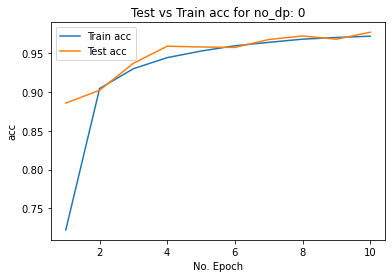

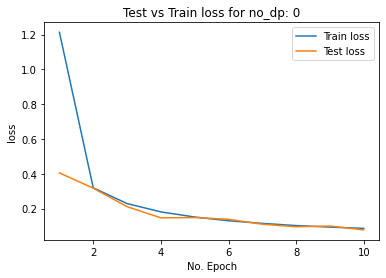

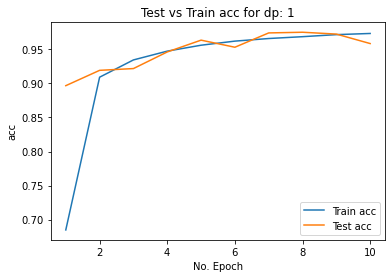

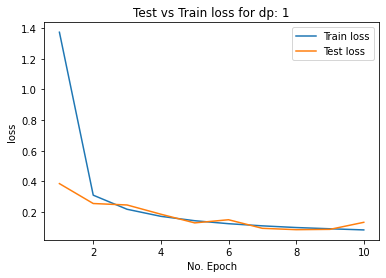

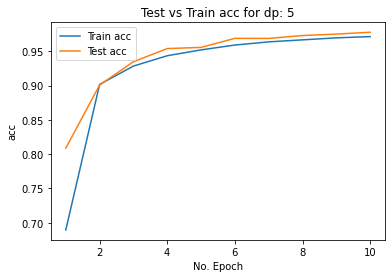

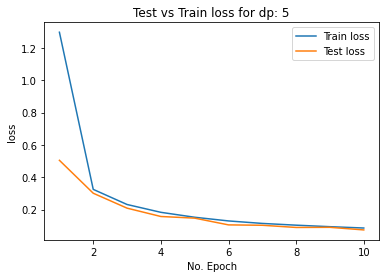

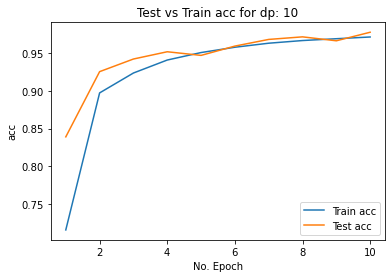

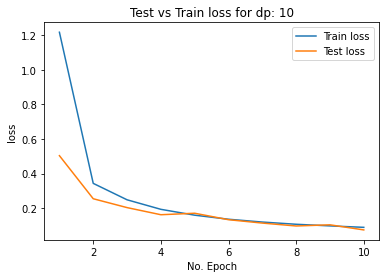

In [106]:
for v in variants:
    d = 'no_dp' if v == 0 else 'dp'
    for m in metrics:
        plot_test_train_graph(d, m, v)

In [107]:

def plot_variants_graph(phase, metric, variants):
    '''
    Plots and saves test train graphs for each metric
    phase: 'test', 'train'
    metric: 'acc', 'loss'
    '''
    
    plt.subplots(facecolor='w')
    for v in variants:
        d = 'no_dp' if v == 0 else 'dp'
        dp_metric = history[f'{phase}_{metric}_{d}_{str(v)}']
        plt.plot(range(1, len(dp_metric) + 1), dp_metric, label=f'{phase} {metric} {d} stddev{v}')
    plt.title(f'DP Comparison {phase} {metric}')
    plt.ylabel(metric)
    plt.xlabel('No. Epoch')
    plt.legend()
    plt.savefig(
        f'./results/dp_comparison_{phase}_{metric}.png'
    )
    plt.show()
    plt.close()

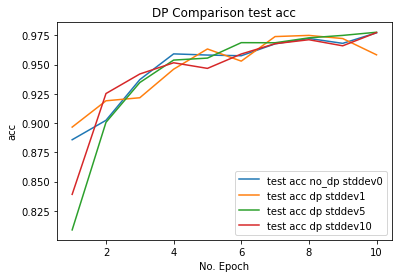

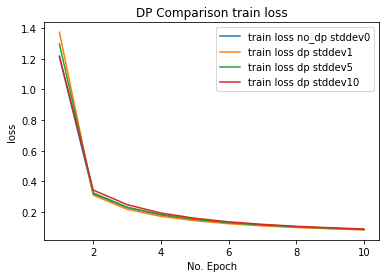

In [108]:
plot_variants_graph('test', 'acc', variants)
plot_variants_graph('train', 'loss', variants)